In [1]:
from VarPro import *
from Utilities import *

# Exact solution in 1D
Numerical resolution of the weighted ultra-fast diffusion in 1d

In [2]:
from scipy.integrate import odeint

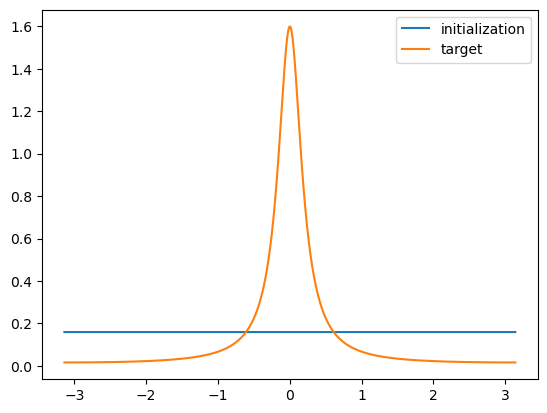

In [3]:
N = 2000

gamma_star = 100
gamma0 = 0

Theta = np.linspace(-np.pi, np.pi, N+1)
Theta = 0.5 * (Theta[1:]+Theta[:-1])

f0 = normalize(1 / (1 + gamma0 * np.cos(Theta/2)**2)) ## initialization
f_star = normalize(1 / (1 + gamma_star * np.sin(Theta/2)**2)) ## target

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(Theta, f0, label='initialization')
ax.plot(Theta, f_star, label='target')
plt.legend()
#ax.axis('equal')

In [4]:
def F(f, t):
    return - 0.5 * f * Laplacian((f_star / f)**2, h=2*np.pi/N) - 0.5 * Grad((f_star / f)**2, h=2*np.pi/N) * Grad(f, h=2*np.pi/N)

In [5]:
t = np.linspace(0, 2000*2**(-10), 1001)
f_list = odeint(F, f0, t)

KeyboardInterrupt: 

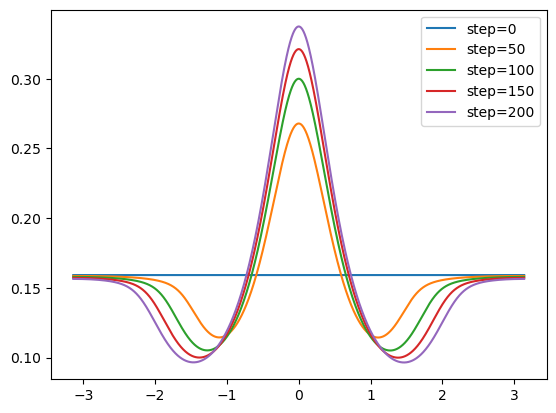

In [ ]:
for i in range(0, 201, 50):
    plt.plot(Theta, f_list[i], label=f'step={i}')
plt.legend()

# ReLU activation 1D
The model is a SHL with ReLU activation taking inputs in 2d and with features and the circle

In [74]:
## Teacher model
activation = nn.ReLU() ## activation function
clipper = FeatureClipper(Normalization())

teacher_width = 10000
teacher = SHL(2, teacher_width, activation, bias=False, clipper=clipper)

gamma = 1000 ## Parameter controling the shape of the target distribution

Theta = np.linspace(-np.pi, np.pi, teacher_width, endpoint=False)
teacher_init = torch.tensor([[np.cos(theta), np.sin(theta)] for theta in Theta], dtype=torch.float32)
teacher_init = teacher_init @ torch.tensor([[(1+gamma)**0.5, 0], [0, 1]], dtype=torch.float32)
teacher_init = teacher_init / torch.norm(teacher_init, 2, dim=-1, keepdim=True).expand_as(teacher_init)
Theta = circle_to_line(teacher_init.numpy())
Theta = 2*Theta

teacher_init = torch.tensor([[np.cos(theta), np.sin(theta)] for theta in Theta], dtype=torch.float32)
#rotation = torch.tensor([[0, -1], [1, 0]], dtype=torch.float32)
#teacher_init[:teacher_width//2] = teacher_init[:teacher_width//2] @ rotation

teacher.feature_model.weight = nn.Parameter(data=teacher_init) ## teacher feature distribution
teacher.outer.weight = nn.Parameter(data=torch.ones_like(teacher.outer.weight), requires_grad=False) ## teacher outer weight

teacher.clipper(teacher)
teacher.apply(freeze)

VarProModel(
  (feature_model): SHLFeatureModel(
    (activation): ReLU()
  )
  (outer): Linear(in_features=10000, out_features=1, bias=False)
)

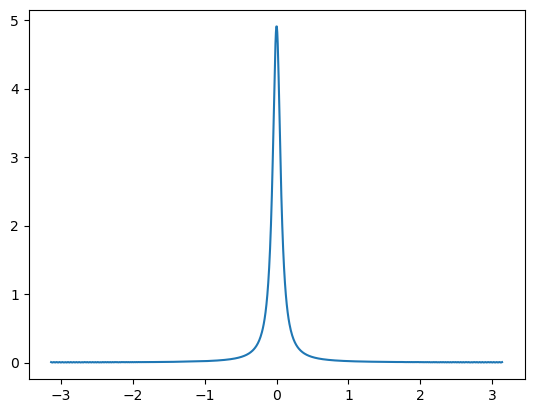

In [75]:
# plot of the teacher feature distribution
f_teacher = circle_to_line(teacher_init.numpy())
plt.plot(*gaussian_conv(f_teacher, scale=0.01))

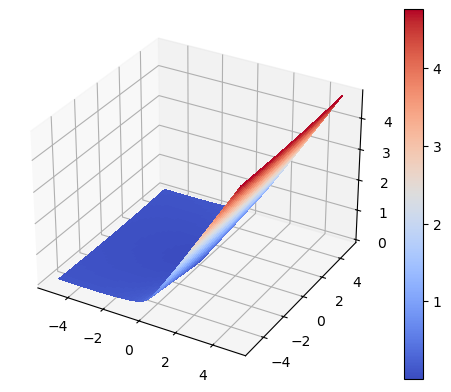

In [76]:
# plot of the teacher signal
_ = model_plot_2d(teacher)

In [77]:
# creating the dataset
N = 2048

inputs = torch.randn(N,2)
targets = teacher(inputs)
dataset = CustomDataset(inputs, targets)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))

In [102]:
## Student model
student_width = 1024
#clipper = FeatureClipper(Normalization())

init = torch.randn((student_width, 2), dtype=torch.float32)

student = SHL(2, student_width, activation, bias=False, clipper=clipper, VarProTraining=True)

student.feature_model.weight = nn.Parameter(data=init.clone().detach(), requires_grad=True)
student.outer.weight = nn.Parameter(data=torch.ones_like(student.outer.weight), requires_grad=False)
student.clipper(student)

In [103]:
## Training
lmbda = 1e-5
time_scale = 2**(-10)
lr = student_width * time_scale

# biased or unbiased loss
#projection = ExactRidgeProjection(lmbda)
#criterion = LeastSquareCriterion(lmbda, projection)
projection = ExactRidgeProjectionUnbiased(lmbda)
criterion = LeastSquareCriterionUnbiased(lmbda, projection)
                                   
optimizer = torch.optim.SGD([student.feature_model.weight], lr=lr)
#optimizer.add_param_group({'lr': 5*student_width*lmbda, 'params': student.outer.weight})

In [104]:
## one projection to set-up outer layer
inputs, targets = next(iter(train_loader))
projection(inputs, targets, student)

In [105]:
problem = LearningProblem(student, train_loader, optimizer, criterion)

In [106]:
problem.train(1000)

log10(loss) = -0.34: 100%|██████████████████| 1000/1000 [00:19<00:00, 51.13it/s]


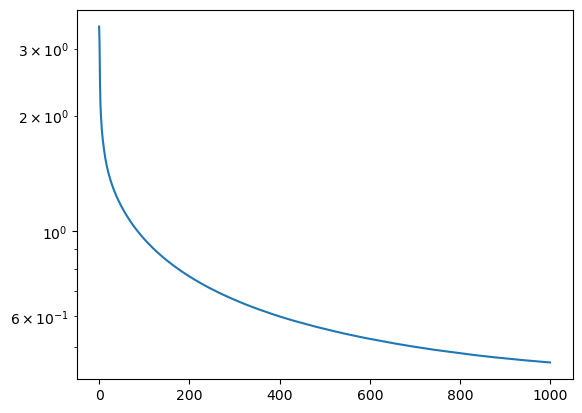

In [107]:
# training loss
plt.plot(problem.loss_list)
plt.yscale('log')
#plt.xscale('log')

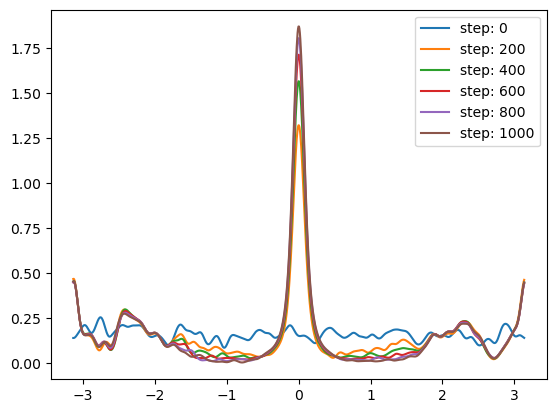

In [109]:
# plot of the learned feature distribution (diracs smoothed with a gaussian)
for i in np.arange(0, 1001, 200):
    w = problem.state_list[i]['feature_model.weight'].numpy()
    f = circle_to_line(w)
    
    plt.plot(*gaussian_conv(f, scale=0.05), label=f'step: {i}')
plt.legend()
#plt.yscale('log')

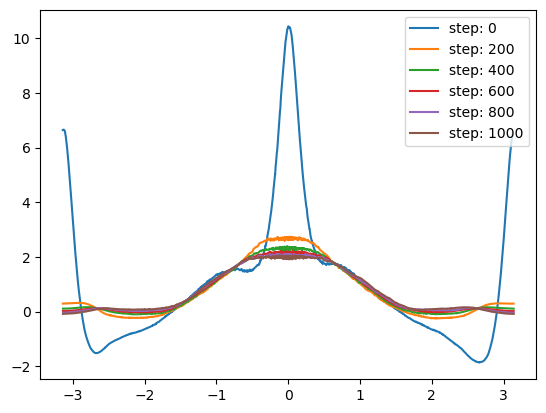

In [111]:
# plot of the outer layer weight (to check if positive and smooth)
for i in np.arange(0, 1001, 200):
    w = problem.state_list[i]['feature_model.weight'].numpy()
    f = circle_to_line(w)
    idx = np.argsort(f)
    u = problem.state_list[i]['outer.weight'].squeeze().numpy()
    
    plt.plot(f[idx], u[idx], label=f'step: {i}')
#plt.yscale('log')
plt.legend()

# Signed SHL with ReLU activation in 1d

In [2]:
## Teacher model
activation = nn.ReLU() ## activation function
weight_clipper = Normalization()
sign_clipper = Thresholding()
clipper = FeatureSignClipper(weight_clipper, sign_clipper)

teacher_width = 10000
teacher = SignedSHL(2, teacher_width, activation, clipper=clipper)

gamma = 100

Theta = np.linspace(-np.pi, np.pi, teacher_width, endpoint=False)
teacher_init = torch.tensor([[np.cos(theta), np.sin(theta)] for theta in Theta], dtype=torch.float32)
teacher_init = teacher_init @ torch.tensor([[(1+gamma)**0.5, 0], [0, 1]], dtype=torch.float32)
teacher_init = teacher_init / torch.norm(teacher_init, 2, dim=-1, keepdim=True).expand_as(teacher_init)
Theta = circle_to_line(teacher_init.numpy())
Theta = 2*Theta

## initial feature distribution with 1 dirac at Theta = 0
teacher_init = torch.tensor([[np.cos(theta), np.sin(theta)] for theta in Theta], dtype=torch.float32)
sign_init = torch.ones(teacher_width, dtype=torch.float32)

## modifying to add diracs
#rotation = torch.tensor([[-1, 0], [0, -1]], dtype=torch.float32)
#teacher_init[::3] = teacher_init[::3] @ rotation

rotation = torch.tensor([[0, -1], [1, 0]], dtype=torch.float32)
teacher_init[1::3] = teacher_init[1::3] @ rotation
sign_init[1::3] = -torch.ones_like(sign_init[1::3], dtype=torch.float32)


teacher.outer.weight = nn.Parameter(data=torch.ones_like(teacher.outer.weight), requires_grad=False)

teacher.feature_model.weight = nn.Parameter(data=teacher_init) ## teacher feature distribution
teacher.feature_model.sign = nn.Parameter(data=sign_init)
teacher.clipper(teacher)
teacher.apply(freeze)

/Users/rbarboni/Documents/GitHub/VarPro/Utilities.py:55: RuntimeWarning: divide by zero encountered in divide
  return 2 * np.arctan( x[:,1] / (1+x[:,0]))


VarProModel(
  (feature_model): SignedSHLFeatureModel(
    (activation): ReLU()
  )
  (outer): Linear(in_features=10000, out_features=1, bias=False)
)

In [3]:
## Data
d = 1
N = 2048

inputs = torch.randn(N,2)
targets = teacher(inputs)
dataset = CustomDataset(inputs, targets)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))

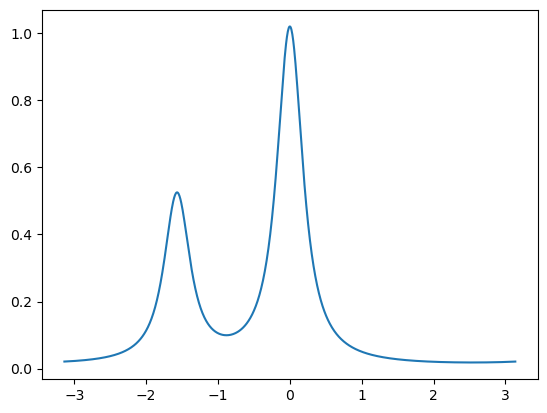

In [4]:
f_teacher = circle_to_line(teacher_init.numpy())
plt.plot(*gaussian_conv(f_teacher, scale=0.05))

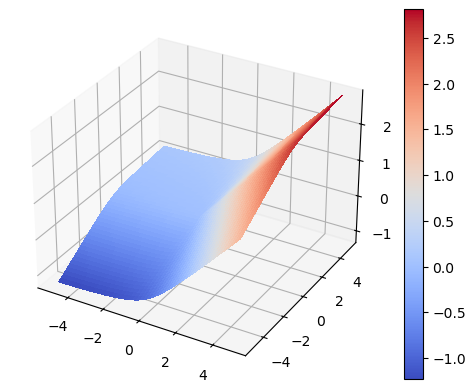

In [5]:
_ = model_plot_2d(teacher)

In [6]:
## Student model
student_width = 256

student = SignedSHL(2, student_width, activation, clipper=clipper, VarProTraining=True)

student.feature_model.weight = nn.Parameter(data=torch.randn((student_width, 2), dtype=torch.float32), requires_grad=True)
student.feature_model.sign = nn.Parameter(data=2*torch.bernoulli(0.5*torch.ones(student_width))-1, requires_grad=True)
student.outer.weight = nn.Parameter(data=torch.ones_like(student.outer.weight), requires_grad=False)
student.clipper(student)

In [7]:
## Training
lmbda = 1e-3
time_scale = 2**(-8)
lr = student_width * time_scale

projection = ExactRidgeProjection(lmbda)
criterion = LeastSquareCriterion(lmbda, projection)
#projection = ExactRidgeProjectionUnbiased(lmbda)
#criterion = LeastSquareCriterionUnbiased(lmbda, projection)
                                   
optimizer = torch.optim.SGD([student.feature_model.weight, student.feature_model.sign], lr=lr)
#optimizer.add_param_group({'lr': 5*student_width*lmbda, 'params': student.outer.weight})

In [8]:
## one projection to set-up outer layer
inputs, targets = next(iter(train_loader))
projection(inputs, targets, student)

In [9]:
problem = LearningProblem(student, train_loader, optimizer, criterion)

In [10]:
problem.train(1000)

log10(loss) = -0.38: 100%|██████████| 1000/1000 [00:09<00:00, 100.89it/s]


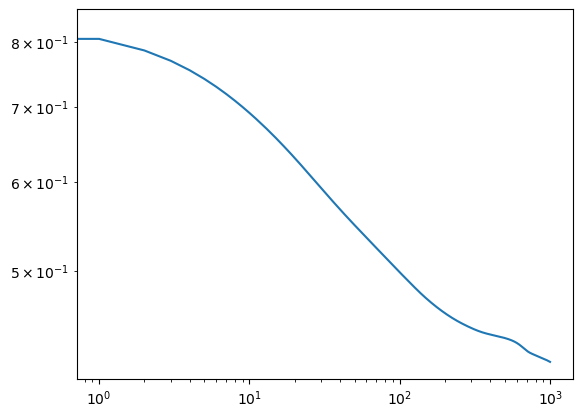

In [11]:
plt.plot(problem.loss_list)
plt.yscale('log')
plt.xscale('log')

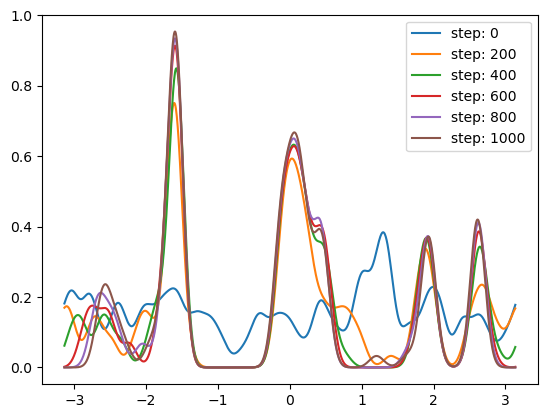

In [12]:
for i in np.arange(0, 1001, 200):
    w = problem.state_list[i]['feature_model.weight'].numpy()
    s = problem.state_list[i]['feature_model.sign'].numpy()
    f = circle_to_line(w)
    
    plt.plot(*gaussian_conv(f[np.argwhere(s>0)], scale=0.1), label=f'step: {i}')
plt.legend()
#plt.yscale('log')

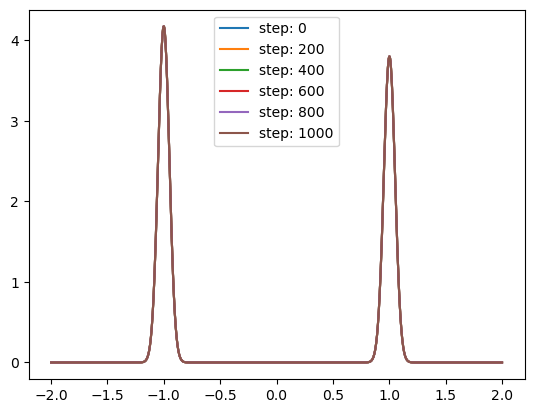

In [13]:
for i in np.arange(0, 1001, 200):
    s = problem.state_list[i]['feature_model.sign'].numpy()
    
    plt.plot(*gaussian_conv(s, interval=(-2,2), scale=0.05), label=f'step: {i}')
plt.legend()
#plt.yscale('log')

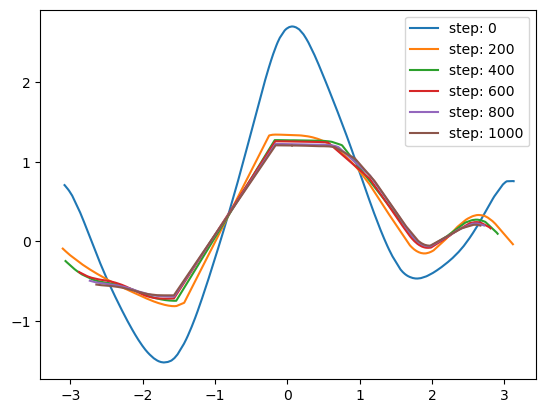

In [14]:
for i in np.arange(0, 1001, 200):
    w = problem.state_list[i]['feature_model.weight'].numpy()
    f = circle_to_line(w)
    idx = np.argsort(f)
    u = problem.state_list[i]['outer.weight'].squeeze().numpy()
    s = problem.state_list[i]['feature_model.sign'].squeeze().numpy()
    
    plt.plot(f[idx], u[idx]*np.sign(s[idx]), label=f'step: {i}')
plt.legend()
#plt.yscale('log')

# Convolution in 1d

In [15]:
## Teacher model
activation = ActivationFunction(lambda t: torch.exp(-t**2)) ## activation function
clipper = FeatureClipper(Normalization())
scale = 0.5

teacher_width = 5000
teacher = Convolution(2, teacher_width, activation, scale=scale, clipper=clipper)

gamma = 100

Theta = np.linspace(-np.pi, np.pi, teacher_width, endpoint=False)
teacher_init = torch.tensor([[np.cos(theta), np.sin(theta)] for theta in Theta], dtype=torch.float32)
teacher_init = teacher_init @ torch.tensor([[(1+gamma)**0.5, 0], [0, 1]], dtype=torch.float32)
teacher_init = teacher_init / torch.norm(teacher_init, 2, dim=-1, keepdim=True).expand_as(teacher_init)
Theta = circle_to_line(teacher_init.numpy())
Theta = 2*Theta

## initial feature distribution with 1 dirac at Theta = 0
teacher_init = torch.tensor([[np.cos(theta), np.sin(theta)] for theta in Theta], dtype=torch.float32)

## modifying to add diracs
#rotation = torch.tensor([[-1, 0], [0, -1]], dtype=torch.float32)
#teacher_init[::3] = teacher_init[::3] @ rotation

rotation = torch.tensor([[0, -1], [1, 0]], dtype=torch.float32)
teacher_init[1::3] = teacher_init[1::3] @ rotation


teacher.outer.weight = nn.Parameter(data=torch.ones_like(teacher.outer.weight), requires_grad=False)

teacher.feature_model.weight = nn.Parameter(data=teacher_init) ## teacher feature distribution
teacher.clipper(teacher)
teacher.apply(freeze)

/Users/rbarboni/Documents/GitHub/VarPro/Utilities.py:55: RuntimeWarning: divide by zero encountered in divide
  return 2 * np.arctan( x[:,1] / (1+x[:,0]))


VarProModel(
  (feature_model): ConvolutionFeatureModel(
    (activation): ActivationFunction()
  )
  (outer): Linear(in_features=5000, out_features=1, bias=False)
)

In [16]:
## Data
d = 1
N = 2048

inputs = torch.randn(N,2)
targets = teacher(inputs)
dataset = CustomDataset(inputs, targets)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))

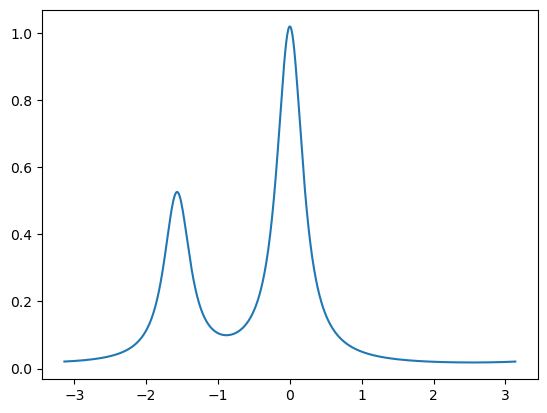

In [17]:
f_teacher = circle_to_line(teacher_init.numpy())
plt.plot(*gaussian_conv(f_teacher, scale=0.05))

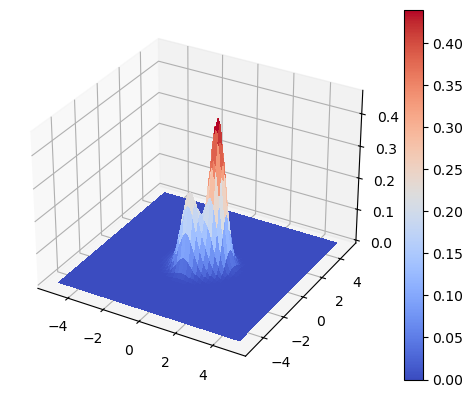

In [18]:
_ = model_plot_2d(teacher)

In [19]:
## Student model
student_width = 512

init = torch.randn((student_width, 2), dtype=torch.float32)

student = Convolution(2, student_width, activation, scale=scale, clipper=clipper, VarProTraining=True)
#student.to(torch.double)

student.feature_model.weight = nn.Parameter(data=init.clone().detach(), requires_grad=True)
student.outer.weight = nn.Parameter(data=torch.ones_like(student.outer.weight), requires_grad=False)
student.clipper(student)

In [20]:
## Training
lmbda = 1e-5
time_scale = 2**(-10)
lr = student_width * time_scale

#projection = ExactRidgeProjection(lmbda)
#criterion = LeastSquareCriterion(lmbda, projection)
projection = ExactRidgeProjectionUnbiased(lmbda)
criterion = LeastSquareCriterionUnbiased(lmbda, projection)
                                   
optimizer = torch.optim.SGD([student.feature_model.weight], lr=lr)
#optimizer.add_param_group({'lr': 5*student_width*lmbda, 'params': student.outer.weight})

In [21]:
## one projection to set-up outer layer
inputs, targets = next(iter(train_loader))
projection(inputs, targets, student)

In [22]:
problem = LearningProblem(student, train_loader, optimizer, criterion)

In [23]:
problem.train(1000)

log10(loss) = -0.82: 100%|██████████| 1000/1000 [00:19<00:00, 52.37it/s]


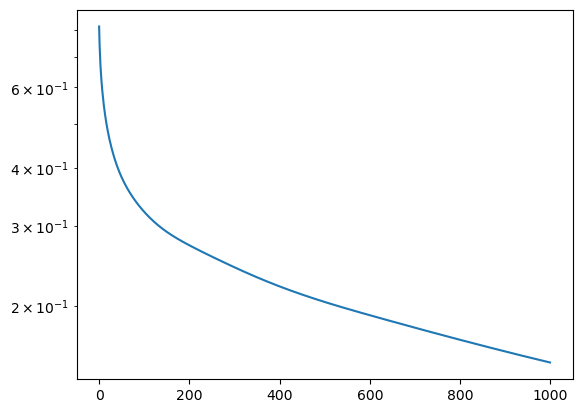

In [25]:
plt.plot(problem.loss_list)
plt.yscale('log')
#plt.xscale('log')

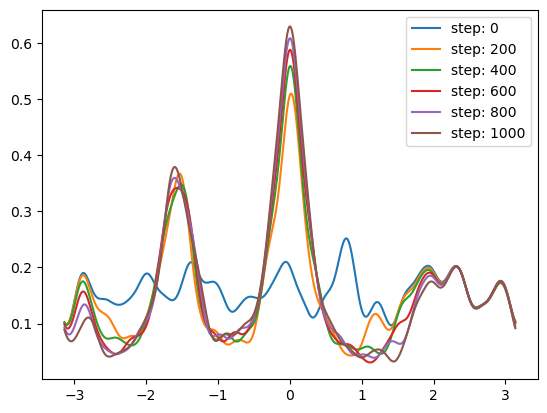

In [26]:
for i in np.arange(0, 1001, 200):
    w = problem.state_list[i]['feature_model.weight'].numpy()
    f = circle_to_line(w)

    #w_SHL = problem_SHL.state_list[i]['feature_model.0.weight'].numpy()
    #f_SHL = circle_to_line(w_SHL)
    
    plt.plot(*gaussian_conv(f, scale=0.1), label=f'step: {i}')
    #plt.plot(*gaussian_conv(f_SHL, scale=0.1), '--')
    #plt.plot(x, f_list[i], '--')
plt.legend()
#plt.yscale('log')

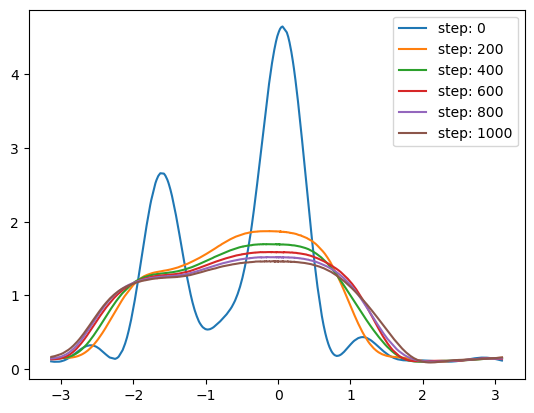

In [27]:
for i in np.arange(0, 1001, 200):
    w = problem.state_list[i]['feature_model.weight'].numpy()
    f = circle_to_line(w)
    idx = np.argsort(f)
    u = problem.state_list[i]['outer.weight'].squeeze().numpy()
    
    plt.plot(f[idx], u[idx], label=f'step: {i}')
   
plt.legend()
#plt.yscale('log')

# SHL with trigonometric activation 2d

In [28]:
## Teacher model
activation = ActivationFunction(torch.cos)

xlim = 3
clipper = FeatureClipper(PeriodicBoundaryCondition(x_min=-xlim, x_max=xlim))

teacher_width = 10000
teacher = SHL(2, teacher_width, activation, bias=False, clipper=clipper)

teacher_weight = 0.1 * torch.randn((teacher_width, 2), dtype=torch.float32)

#teacher_weight = xlim * (2 * torch.rand((teacher_width, 2), dtype=torch.float32) - 1)
#teacher_bias = np.pi * torch.rand(teacher_width, dtype=torch.float32)

teacher.feature_model.weight = nn.Parameter(data=teacher_weight) ## teacher feature distribution
#teacher.feature_model.bias = nn.Parameter(data=teacher_bias)

teacher.outer.weight = nn.Parameter(data=torch.ones_like(teacher.outer.weight), requires_grad=False)

teacher.clipper(teacher)
teacher.apply(freeze)

VarProModel(
  (feature_model): SHLFeatureModel(
    (activation): ActivationFunction()
  )
  (outer): Linear(in_features=10000, out_features=1, bias=False)
)

In [29]:
# data
N = 2048

inputs = torch.randn(N,2)
targets = teacher(inputs)
dataset = CustomDataset(inputs, targets)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))

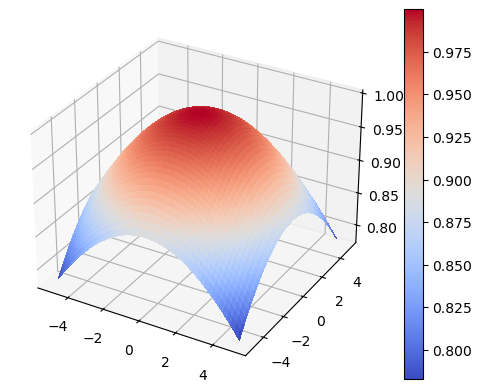

In [30]:
_ = model_plot_2d(teacher)

In [31]:
## Student model
#clipper = FeatureClipper(PeriodicBoundaryCondition(x_min=-xlim, x_max=xlim))
clipper = FeatureBiasClipper(PeriodicBoundaryCondition(x_min=-xlim, x_max=xlim),
                                PeriodicBoundaryCondition(x_min=-np.pi, x_max=np.pi))

student_width = 256

student = SHL(2, student_width, activation, bias=True, clipper=clipper, VarProTraining=True)


weight_init = xlim * (2 * torch.rand((student_width, 2), dtype=torch.float32) - 1)
bias_init = np.pi * (2*torch.rand(student_width, dtype=torch.float32)-1)

student.feature_model.weight = nn.Parameter(data=weight_init.clone().detach(), requires_grad=True)
student.feature_model.bias = nn.Parameter(data=bias_init.clone().detach(), requires_grad=True)

student.clipper(student)

In [32]:
### Training
lmbda = 1e-3
time_scale = 2**(-10)
lr = student_width * time_scale

# biased or unbiased loss
projection = ExactRidgeProjection(lmbda)
criterion = LeastSquareCriterion(lmbda, projection)
#projection = ExactRidgeProjectionUnbiased(lmbda) 
#criterion = LeastSquareCriterionUnbiased(lmbda, projection)
                                   
optimizer = torch.optim.SGD([student.feature_model.weight, student.feature_model.bias], lr=lr)

In [33]:
## one projection to set-up outer layer
inputs, targets = next(iter(train_loader))
projection(inputs, targets, student)

In [34]:
problem = LearningProblem(student, train_loader, optimizer, criterion)

In [35]:
problem.train(2000)

log10(loss) = 0.20: 100%|██████████| 2000/2000 [00:17<00:00, 112.43it/s]


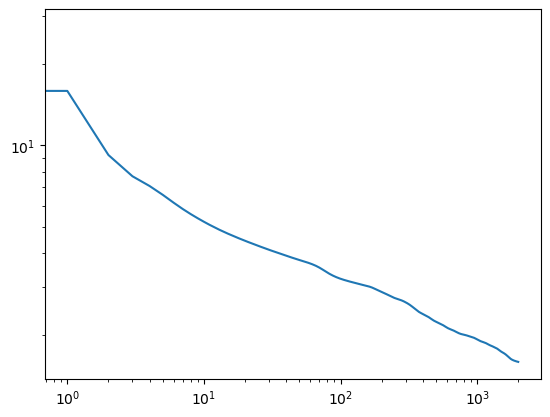

In [36]:
plt.plot(problem.loss_list)
plt.yscale('log')
plt.xscale('log')

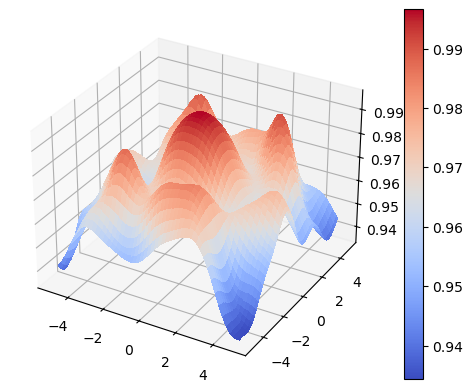

In [37]:
_ = model_plot_2d(student)

In [38]:
w_array = np.array([dico['feature_model.weight'].numpy() for dico in problem.state_list]) 

weight_animation_2d(w_array, name='SHL_2d_animation.mp4')

NameError: name 'weight_animation_2d' is not defined

# Convolution 2d

In [116]:
## Teacher model
activation = ActivationFunction(lambda t: torch.exp(-t**2))
scale = 1

xlim = 3
clipper = FeatureClipper(PeriodicBoundaryCondition(x_min=-xlim, x_max=xlim))

teacher_width = 1000
teacher = Convolution(2, teacher_width, activation, scale, clipper=clipper)

teacher_weight = 0.1 * torch.randn((teacher_width, 2), dtype=torch.float32)

teacher.feature_model.weight = nn.Parameter(data=teacher_weight) ## teacher feature distribution
#teacher.feature_model.bias = nn.Parameter(data=teacher_bias)

teacher.clipper(teacher)

teacher.outer.weight = nn.Parameter(data=torch.ones_like(teacher.outer.weight), requires_grad=False)

teacher.apply(freeze)

VarProModel(
  (feature_model): ConvolutionFeatureModel(
    (activation): ActivationFunction()
  )
  (outer): Linear(in_features=1000, out_features=1, bias=False)
)

In [117]:
# data
N = 2048

inputs = torch.randn(N,2)
targets = teacher(inputs)
dataset = CustomDataset(inputs, targets)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))

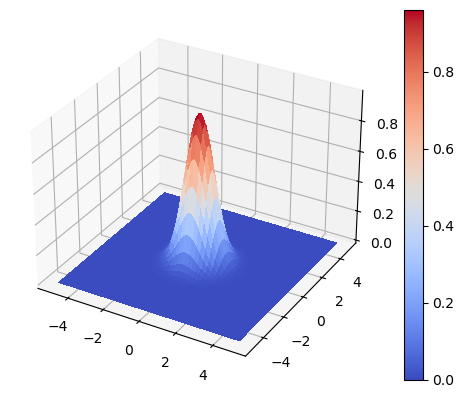

In [118]:
_ = model_plot_2d(teacher)

In [136]:
## Student model
student_width = 256

student = Convolution(2, student_width, activation, scale=scale, clipper=clipper, VarProTraining=True)

weight_init = xlim * (2 * torch.rand((student_width, 2), dtype=torch.float32) - 1)

student.feature_model.weight = nn.Parameter(data=weight_init.clone().detach(), requires_grad=True)

student.clipper(student)

In [137]:
### Training
lmbda = 1e-3
time_scale = 2**(-10)
lr = student_width * time_scale

# biased or unbiased loss
#projection = ExactRidgeProjection(lmbda)
#criterion = LeastSquareCriterion(lmbda, projection)
projection = ExactRidgeProjectionUnbiased(lmbda) 
criterion = LeastSquareCriterionUnbiased(lmbda, projection)
                                   
optimizer = torch.optim.SGD([student.feature_model.weight], lr=lr)

In [138]:
## one projection to set-up outer layer
inputs, targets = next(iter(train_loader))
projection(inputs, targets, student)

In [139]:
problem = LearningProblem(student, train_loader, optimizer, criterion)

In [140]:
problem.train(8000)

log10(loss) = -0.31: 100%|██████████████████| 8000/8000 [01:27<00:00, 91.49it/s]


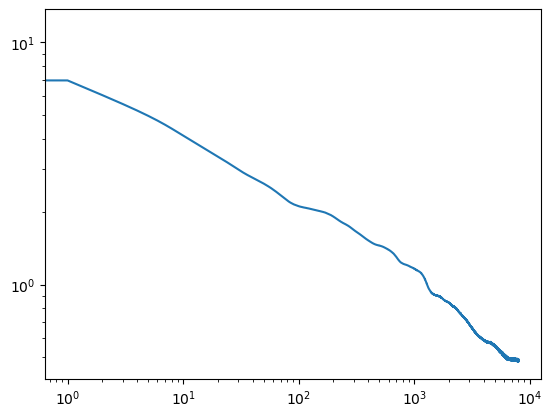

In [141]:
plt.plot(problem.loss_list)
#plt.plot(problem_SHL.loss_list)
plt.yscale('log')
plt.xscale('log')

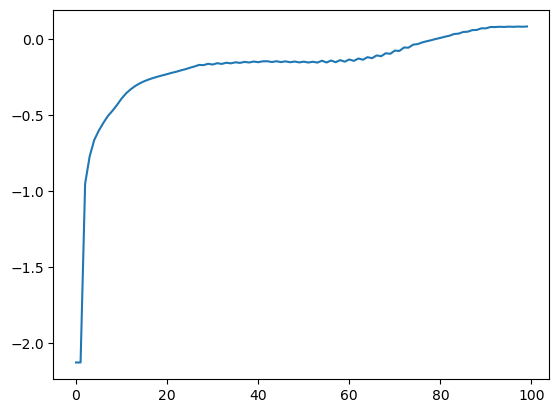

In [143]:
min_list = [state['outer.weight'].min() for state in problem.state_list]
plt.plot(min_list)
#plt.yscale('log')

In [128]:
problem.state_list[0]['outer.weight']

tensor([[ 2.0751e+01, -1.0493e-01, -2.7846e-01, -1.9841e-01, -2.3875e+00,
         -2.3762e-02,  9.3892e-01, -1.1974e+00, -1.8127e+00, -5.3605e-01,
         -3.8252e-01,  2.8153e-02,  1.3367e+01,  9.9862e-03, -7.8565e-01,
         -1.4522e+00, -8.5634e-01, -3.6486e-01, -2.5018e-01,  4.1789e-02,
          3.4690e-01, -4.4568e-02, -6.4939e-01, -4.7743e-01, -2.5808e-01,
         -1.9326e+00,  1.2439e+00, -2.3835e-01, -1.1166e+00,  7.0957e-03,
         -5.7017e-01, -1.8293e+00, -2.2614e-01,  1.2337e+00, -2.0471e+00,
          4.2841e-02, -9.1158e-01, -1.5468e+00, -3.0648e-01, -4.9925e-01,
         -1.0811e+00,  3.0002e-01,  3.0997e+00,  8.8892e-03, -1.1858e+00,
          1.4290e+01, -9.2182e-01, -2.3067e+00,  1.0989e+00, -2.1315e+00,
         -1.0455e+00,  2.5436e+00,  6.2725e-02, -4.3908e-01, -3.2429e-01,
         -8.9091e-01, -8.4914e-01, -4.3394e-02, -8.1520e-02, -6.0726e-01,
          4.5469e-02,  3.8249e-02,  1.3130e+01, -9.2329e-01, -5.1412e-02,
          9.4223e-01, -8.1422e-01, -3.

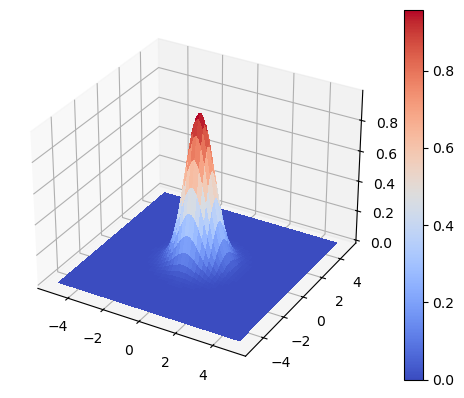

In [126]:
_ = model_plot_2d(student)

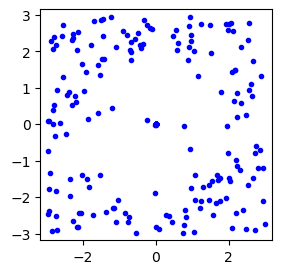

In [ ]:
w_array = np.array([dico['feature_model.weight'].numpy() for dico in problem.state_list]) 

weight_animation_2d(w_array, name='Convolution_2d_animation.mp4')

# Convolution in n-dim

The goal is to check if VarPro always result in positive weights on the outer layer

In [257]:
## Teacher model
d = 3 # dimension

activation = ActivationFunction(lambda t: torch.exp(-t))
scale = 0.3

clipper = FeatureClipper(Normalization())

teacher_width = 10000
teacher = Convolution(d, teacher_width, activation, scale, clipper=clipper)

omega0 = torch.ones(d)
omega1 = torch.tensor([1, 0, 0])
teacher_weight = 0.1*torch.randn((teacher_width, d), dtype=torch.float32)
teacher_weight[::2] = teacher_weight[::2] + omega0[None,:]
teacher_weight[1::2] = teacher_weight[1::2] + omega1[None,:]

teacher.feature_model.weight = nn.Parameter(data=teacher_weight) ## teacher feature distribution
#teacher.feature_model.bias = nn.Parameter(data=teacher_bias)

teacher.clipper(teacher)
teacher.outer.weight = nn.Parameter(data=torch.ones_like(teacher.outer.weight), requires_grad=False)
teacher.apply(freeze)

VarProModel(
  (feature_model): ConvolutionFeatureModel(
    (activation): ActivationFunction()
  )
  (outer): Linear(in_features=10000, out_features=1, bias=False)
)

In [258]:
# data
N = 2048

inputs = torch.randn(N,d)
targets = teacher(inputs)
dataset = CustomDataset(inputs, targets)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))

In [259]:
## Student model
student_width = 256

student = Convolution(d, student_width, activation, scale=scale, clipper=clipper, VarProTraining=True)

weight_init = torch.randn((student_width, d), dtype=torch.float32)

student.feature_model.weight = nn.Parameter(data=weight_init.clone().detach(), requires_grad=True)

student.clipper(student)

In [260]:
### Training
lmbda = 1e-3
time_scale = 2**(-10)
lr = student_width * time_scale

# biased or unbiased loss
#projection = ExactRidgeProjection(lmbda)
#criterion = LeastSquareCriterion(lmbda, projection)
projection = ExactRidgeProjectionUnbiased(lmbda) 
criterion = LeastSquareCriterionUnbiased(lmbda, projection)
                                   
optimizer = torch.optim.SGD([student.feature_model.weight], lr=lr)

In [261]:
## one projection to set-up outer layer
inputs, targets = next(iter(train_loader))
projection(inputs, targets, student)

In [262]:
problem = LearningProblem(student, train_loader, optimizer, criterion)

In [263]:
problem.train(1000)

log10(loss) = -0.63: 100%|██████████████████| 1000/1000 [00:10<00:00, 95.03it/s]


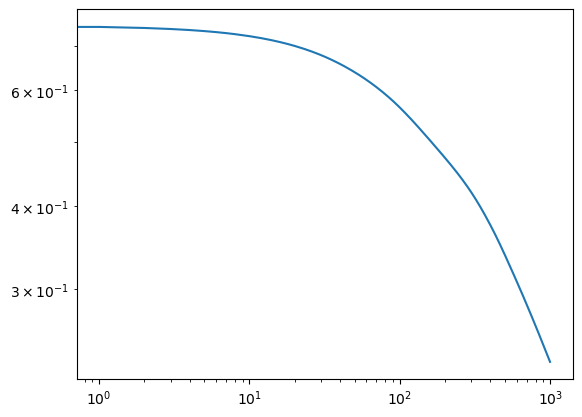

In [264]:
plt.plot(problem.loss_list)
#plt.plot(problem_SHL.loss_list)
plt.yscale('log')
plt.xscale('log')

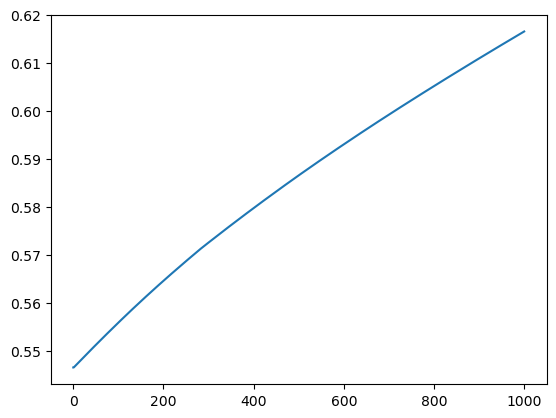

In [265]:
min_list = [state['outer.weight'].min() for state in problem.state_list]
plt.plot(min_list)